<a href="https://colab.research.google.com/github/plaban1981/Fastai/blob/master/Disaster_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!unzip "/content/drive/My Drive/Adrain/Cyclone_Wildfire_Flood_Earthquake_Database.zip" -d "/content/drive/My Drive/"

# Build montages for images

In [9]:
import cv2
from imutils import paths
imagePaths_Cyclone = list(paths.list_images("/content/drive/My Drive/Cyclone_Wildfire_Flood_Earthquake_Database/Cyclone"))
imagePaths_Earthquake = list(paths.list_images("/content/drive/My Drive/Cyclone_Wildfire_Flood_Earthquake_Database/Earthquake"))
imagePaths_Flood = list(paths.list_images("/content/drive/My Drive/Cyclone_Wildfire_Flood_Earthquake_Database/Flood"))
imagePaths_WildFire = list(paths.list_images("/content/drive/My Drive/Cyclone_Wildfire_Flood_Earthquake_Database/Wildfire"))


In [2]:
images = []
for imagep in imagePaths_Earthquake[:26] :
  image = cv2.imread(imagep)
  images.append(image)

#### **Construct Montages for images**

In [3]:
from imutils import build_montages
montages = build_montages(images,(128,128),(5,3))

#### **loop over montages and display each item -Cyclone**

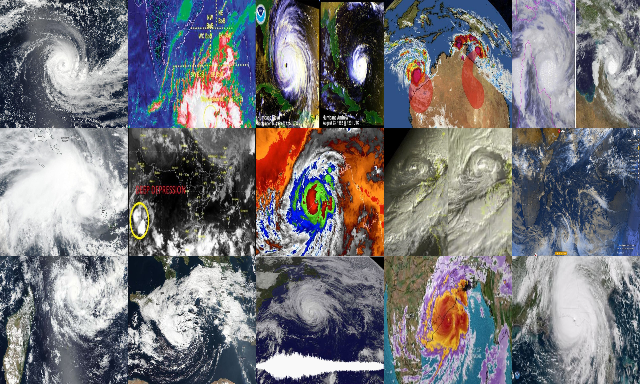

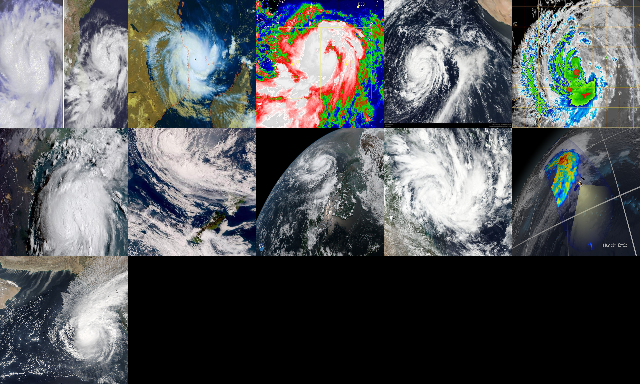

In [ ]:
from google.colab.patches import cv2_imshow
for montage in montages :
  cv2_imshow(montage)


#### **loop over montages and display each item -Earthquake**

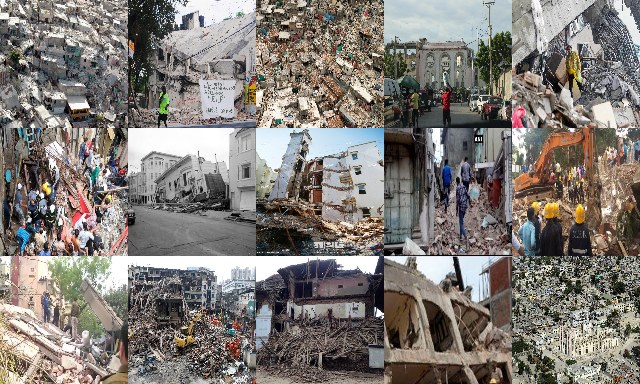

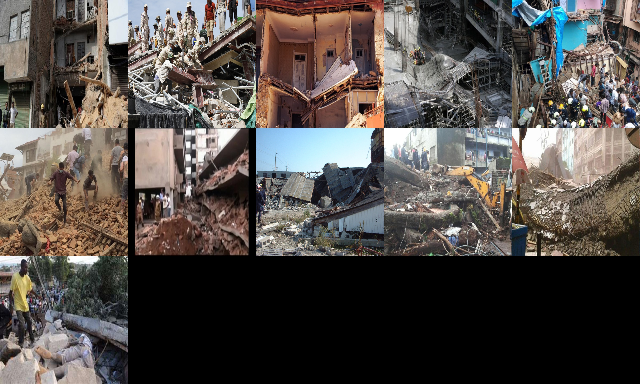

In [ ]:
from google.colab.patches import cv2_imshow
for montage in montages :
  cv2_imshow(montage)

#### **Build montages for Flood**

In [ ]:
images = []
for imagep in imagePaths_Flood[:26] :
  image = cv2.imread(imagep)
  images.append(image)

In [ ]:
from imutils import build_montages
montages = build_montages(images,(128,128),(5,3))

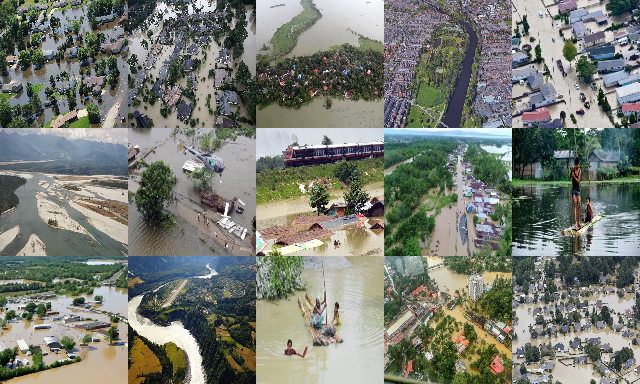

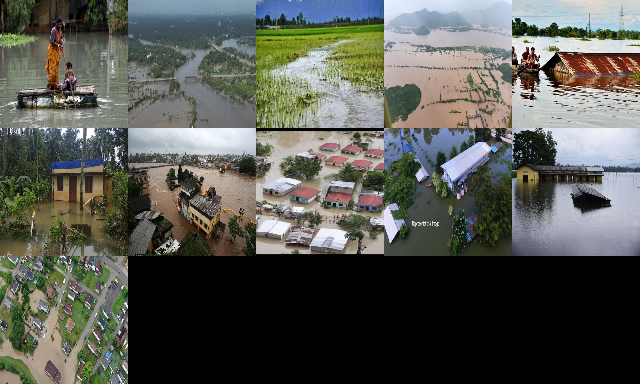

In [ ]:
from google.colab.patches import cv2_imshow
for montage in montages :
  cv2_imshow(montage)

#### **Build montages for Wild Fire**

In [ ]:
images = []
for imagep in imagePaths_WildFire[:26] :
  image = cv2.imread(imagep)
  images.append(image)

In [ ]:
from imutils import build_montages
montages = build_montages(images,(128,128),(5,3))

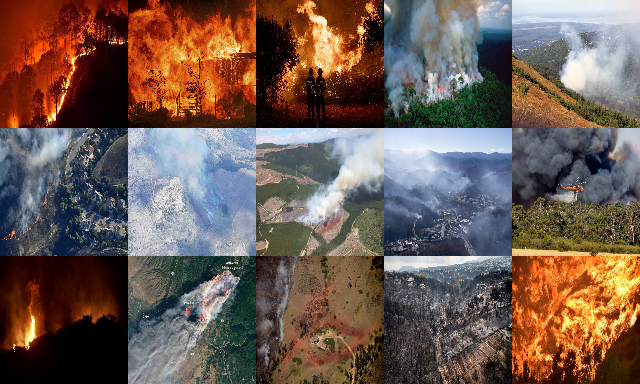

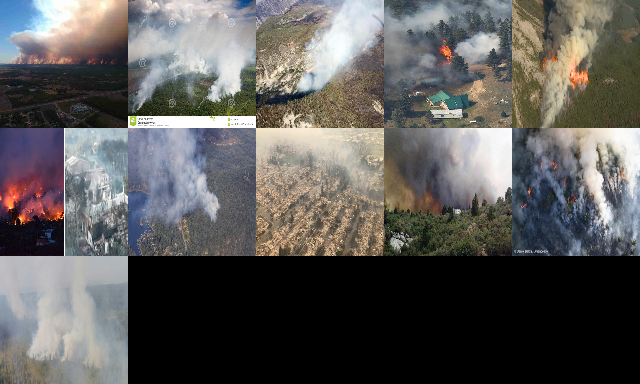

In [ ]:
from google.colab.patches import cv2_imshow
for montage in montages :
  cv2_imshow(montage)

## Classification using Keras

In [31]:
import matplotlib
matplotlib.use("Agg")
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
#
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import *
import tempfile
#
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import pickle
import cv2
import sys
import os

## Define Cyclic Learning rate Class

In [5]:
class CyclicLR(Callback):
	"""This callback implements a cyclical learning rate policy (CLR).
	The method cycles the learning rate between two boundaries with
	some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
	The amplitude of the cycle can be scaled on a per-iteration or
	per-cycle basis.
	This class has three built-in policies, as put forth in the paper.
	"triangular":
		A basic triangular cycle w/ no amplitude scaling.
	"triangular2":
		A basic triangular cycle that scales initial amplitude by half each cycle.
	"exp_range":
		A cycle that scales initial amplitude by gamma**(cycle iterations) at each
		cycle iteration.
	For more detail, please see paper.

	# Example
		```python
			clr = CyclicLR(base_lr=0.001, max_lr=0.006,
								step_size=2000., mode='triangular')
			model.fit(X_train, Y_train, callbacks=[clr])
		```

	Class also supports custom scaling functions:
		```python
			clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
			clr = CyclicLR(base_lr=0.001, max_lr=0.006,
								step_size=2000., scale_fn=clr_fn,
								scale_mode='cycle')
			model.fit(X_train, Y_train, callbacks=[clr])
		```
	# Arguments
		base_lr: initial learning rate which is the
			lower boundary in the cycle.
		max_lr: upper boundary in the cycle. Functionally,
			it defines the cycle amplitude (max_lr - base_lr).
			The lr at any cycle is the sum of base_lr
			and some scaling of the amplitude; therefore
			max_lr may not actually be reached depending on
			scaling function.
		step_size: number of training iterations per
			half cycle. Authors suggest setting step_size
			2-8 x training iterations in epoch.
		mode: one of {triangular, triangular2, exp_range}.
			Default 'triangular'.
			Values correspond to policies detailed above.
			If scale_fn is not None, this argument is ignored.
		gamma: constant in 'exp_range' scaling function:
			gamma**(cycle iterations)
		scale_fn: Custom scaling policy defined by a single
			argument lambda function, where
			0 <= scale_fn(x) <= 1 for all x >= 0.
			mode paramater is ignored
		scale_mode: {'cycle', 'iterations'}.
			Defines whether scale_fn is evaluated on
			cycle number or cycle iterations (training
			iterations since start of cycle). Default is 'cycle'.
	"""

	def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
				 gamma=1., scale_fn=None, scale_mode='cycle'):
		super(CyclicLR, self).__init__()

		self.base_lr = base_lr
		self.max_lr = max_lr
		self.step_size = step_size
		self.mode = mode
		self.gamma = gamma
		if scale_fn == None:
			if self.mode == 'triangular':
				self.scale_fn = lambda x: 1.
				self.scale_mode = 'cycle'
			elif self.mode == 'triangular2':
				self.scale_fn = lambda x: 1 / (2. ** (x - 1))
				self.scale_mode = 'cycle'
			elif self.mode == 'exp_range':
				self.scale_fn = lambda x: gamma ** (x)
				self.scale_mode = 'iterations'
		else:
			self.scale_fn = scale_fn
			self.scale_mode = scale_mode
		self.clr_iterations = 0.
		self.trn_iterations = 0.
		self.history = {}

		self._reset()

	def _reset(self, new_base_lr=None, new_max_lr=None,
			   new_step_size=None):
		"""Resets cycle iterations.
		Optional boundary/step size adjustment.
		"""
		if new_base_lr != None:
			self.base_lr = new_base_lr
		if new_max_lr != None:
			self.max_lr = new_max_lr
		if new_step_size != None:
			self.step_size = new_step_size
		self.clr_iterations = 0.

	def clr(self):
		cycle = np.floor(1 + self.clr_iterations / (2 * self.step_size))
		x = np.abs(self.clr_iterations / self.step_size - 2 * cycle + 1)
		if self.scale_mode == 'cycle':
			return self.base_lr + (self.max_lr - self.base_lr) * np.maximum(0, (1 - x)) * self.scale_fn(cycle)
		else:
			return self.base_lr + (self.max_lr - self.base_lr) * np.maximum(0, (1 - x)) * self.scale_fn(
				self.clr_iterations)

	def on_train_begin(self, logs={}):
		logs = logs or {}

		if self.clr_iterations == 0:
			K.set_value(self.model.optimizer.lr, self.base_lr)
		else:
			K.set_value(self.model.optimizer.lr, self.clr())

	def on_batch_end(self, epoch, logs=None):

		logs = logs or {}
		self.trn_iterations += 1
		self.clr_iterations += 1

		self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
		self.history.setdefault('iterations', []).append(self.trn_iterations)

		for k, v in logs.items():
			self.history.setdefault(k, []).append(v)

		K.set_value(self.model.optimizer.lr, self.clr())


# Define Optimum Learning rate finder

In [6]:
class LearningRateFinder:
	def __init__(self, model, stopFactor=4, beta=0.98):
		# store the model, stop factor, and beta value (for computing
		# a smoothed, average loss)
		self.model = model
		self.stopFactor = stopFactor
		self.beta = beta

		# initialize our list of learning rates and losses,
		# respectively
		self.lrs = []
		self.losses = []

		# initialize our learning rate multiplier, average loss, best
		# loss found thus far, current batch number, and weights file
		self.lrMult = 1
		self.avgLoss = 0
		self.bestLoss = 1e9
		self.batchNum = 0
		self.weightsFile = None

	def reset(self):
		# re-initialize all variables from our constructor
		self.lrs = []
		self.losses = []
		self.lrMult = 1
		self.avgLoss = 0
		self.bestLoss = 1e9
		self.batchNum = 0
		self.weightsFile = None

	def is_data_iter(self, data):
		# define the set of class types we will check for
		iterClasses = ["NumpyArrayIterator", "DirectoryIterator",
			 "DataFrameIterator", "Iterator", "Sequence"]

		# return whether our data is an iterator
		return data.__class__.__name__ in iterClasses

	def on_batch_end(self, batch, logs):
		# grab the current learning rate and add log it to the list of
		# learning rates that we've tried
		lr = K.get_value(self.model.optimizer.lr)
		self.lrs.append(lr)

		# grab the loss at the end of this batch, increment the total
		# number of batches processed, compute the average average
		# loss, smooth it, and update the losses list with the
		# smoothed value
		l = logs["loss"]
		self.batchNum += 1
		self.avgLoss = (self.beta * self.avgLoss) + ((1 - self.beta) * l)
		smooth = self.avgLoss / (1 - (self.beta ** self.batchNum))
		self.losses.append(smooth)

		# compute the maximum loss stopping factor value
		stopLoss = self.stopFactor * self.bestLoss

		# check to see whether the loss has grown too large
		if self.batchNum > 1 and smooth > stopLoss:
			# stop returning and return from the method
			self.model.stop_training = True
			return

		# check to see if the best loss should be updated
		if self.batchNum == 1 or smooth < self.bestLoss:
			self.bestLoss = smooth

		# increase the learning rate
		lr *= self.lrMult
		K.set_value(self.model.optimizer.lr, lr)

	def find(self, trainData, startLR, endLR, epochs=None,
		stepsPerEpoch=None, batchSize=32, sampleSize=2048,
		verbose=1):
		# reset our class-specific variables
		self.reset()

		# determine if we are using a data generator or not
		useGen = self.is_data_iter(trainData)

		# if we're using a generator and the steps per epoch is not
		# supplied, raise an error
		if useGen and stepsPerEpoch is None:
			msg = "Using generator without supplying stepsPerEpoch"
			raise Exception(msg)

		# if we're not using a generator then our entire dataset must
		# already be in memory
		elif not useGen:
			# grab the number of samples in the training data and
			# then derive the number of steps per epoch
			numSamples = len(trainData[0])
			stepsPerEpoch = np.ceil(numSamples / float(batchSize))

		# if no number of training epochs are supplied, compute the
		# training epochs based on a default sample size
		if epochs is None:
			epochs = int(np.ceil(sampleSize / float(stepsPerEpoch)))

		# compute the total number of batch updates that will take
		# place while we are attempting to find a good starting
		# learning rate
		numBatchUpdates = epochs * stepsPerEpoch

		# derive the learning rate multiplier based on the ending
		# learning rate, starting learning rate, and total number of
		# batch updates
		self.lrMult = (endLR / startLR) ** (1.0 / numBatchUpdates)

		# create a temporary file path for the model weights and
		# then save the weights (so we can reset the weights when we
		# are done)
		self.weightsFile = tempfile.mkstemp()[1]
		self.model.save_weights(self.weightsFile)

		# grab the *original* learning rate (so we can reset it
		# later), and then set the *starting* learning rate
		origLR = K.get_value(self.model.optimizer.lr)
		K.set_value(self.model.optimizer.lr, startLR)

		# construct a callback that will be called at the end of each
		# batch, enabling us to increase our learning rate as training
		# progresses
		callback = LambdaCallback(on_batch_end=lambda batch, logs:
			self.on_batch_end(batch, logs))

		# check to see if we are using a data iterator
		if useGen:
			self.model.fit_generator(
				trainData,
				steps_per_epoch=stepsPerEpoch,
				epochs=epochs,
				verbose=verbose,
				callbacks=[callback])

		# otherwise, our entire training data is already in memory
		else:
			# train our model using Keras' fit method
			self.model.fit(
				trainData[0], trainData[1],
				batch_size=batchSize,
				epochs=epochs,
				callbacks=[callback],
				verbose=verbose)

		# restore the original model weights and learning rate
		self.model.load_weights(self.weightsFile)
		K.set_value(self.model.optimizer.lr, origLR)

	def plot_loss(self, skipBegin=10, skipEnd=1, title=""):
		# grab the learning rate and losses values to plot
		lrs = self.lrs[skipBegin:-skipEnd]
		losses = self.losses[skipBegin:-skipEnd]

		# plot the learning rate vs. loss
		plt.plot(lrs, losses)
		plt.xscale("log")
		plt.xlabel("Learning Rate (Log Scale)")
		plt.ylabel("Loss")

		# if the title is not empty, add it to the plot
		if title != "":
			plt.title(title)

In [10]:
path = "/content/drive/My Drive/Cyclone_Wildfire_Flood_Earthquake_Database"
os.listdir(path)

['Earthquake', 'Flood', 'Wildfire', 'Cyclone']

In [11]:
# initialize the class labels in the dataset
CLASSES = ["Cyclone", "Earthquake", "Flood", "Wildfire"]

####  **Define the size of the training, validati(which comes from the train split), and testing splits, respectively**

In [12]:
TRAIN_SPLIT = 0.75
VAL_SPLIT = 0.1 #validation split is 10% of the training split
TEST_SPLIT = 0.25

#### **set the path to the serialized model after training**

In [13]:
MODEL_PATH = os.path.sep.join(["output", "natural_disaster.model"])

# define the path to the output learning rate finder plot, training history plot and cyclical learning rate plot

In [14]:
LRFIND_PLOT_PATH = os.path.sep.join(["output", "lrfind_plot.png"])
TRAINING_PLOT_PATH = os.path.sep.join(["output", "training_plot.png"])
CLR_PLOT_PATH = os.path.sep.join(["output", "clr_plot.png"])

#Grab the paths to all images in our dataset directory and initialize our lists of images and class labels

In [15]:
print("[INFO] loading images...")
imagePaths = list(paths.list_images("/content/drive/My Drive/Cyclone_Wildfire_Flood_Earthquake_Database"))
data = []
labels = []

[INFO] loading images...


## Steps
* loop over the image paths
* extract the class label
* load the image, convert it to RGB channel ordering, and resize it to be a fixed 224x224 pixels
* update the data and labels lists, respectively

In [23]:
data = []
labels = []
for imagePath in imagePaths:
  label = imagePath.split(os.path.sep)[-2]
  #print(label)
  image = cv2.imread(imagePath)
  image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  data.append(image)
  labels.append(label)

# Convert the data and labels to NumPy arrays

In [24]:
print("[INFO] processing data...")
data = np.array(data, dtype="float32")
labels = np.array(labels)

[INFO] processing data...


In [25]:
data.shape,labels.shape

((4428, 224, 224, 3), (4428,))

In [57]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

In [58]:
labels

array([[0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       ...,
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0]])

# Split the data into training dataset and validation set

In [59]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=TEST_SPLIT, random_state=42)

# take the validation split from the training split

In [60]:
(trainX, valX, trainY, valY) = train_test_split(trainX, trainY,test_size=VAL_SPLIT, random_state=84)

# Data Augmentation

In [61]:
aug = ImageDataGenerator(
	rotation_range=30,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

# Transfer Learning

**load the ResNet152V2 network, ensuring the head FC layer sets are left off**

In [32]:
baseModel = ResNet152V2(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))

234553344/234545216 [==============================] - 8s 0us/step


In [71]:
baseModel = VGG16(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))

58892288/58889256 [==============================] - 2s 0us/step


In [33]:
baseModel.summary()

Model: "resnet152v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
________________________________________________________________________________________

In [47]:
CLASSES = ["Cyclone", "Earthquake", "Flood", "Wildfire"]

# Construct the head of the model that will be placed on top of the the base model

In [72]:
headModel = baseModel.output
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(512, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(len(CLASSES), activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become the actual model we will train)

In [73]:
model = Model(inputs=baseModel.input, outputs=headModel)

In [74]:
model.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

# loop over all layers in the base model and freeze them so they will *not* be updated during the first training process

In [75]:
for layer in baseModel.layers:
	layer.trainable = False

# define the minimum learning rate, maximum learning rate, batch size,step size, CLR method, and number of epochs

In [76]:
MIN_LR = 1e-6
MAX_LR = 1e-4
BATCH_SIZE = 32
STEP_SIZE = 8
CLR_METHOD = "triangular"
NUM_EPOCHS = 48

# Compile our model (this needs to be done after our setting our layers to being non-trainable

In [77]:
print("[INFO] compiling model...")
opt = SGD(lr=MIN_LR, momentum=0.9)
model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])

[INFO] compiling model...


In [53]:
np.ceil((trainX.shape[0] / float(BATCH_SIZE)))

94.0

In [68]:
trainX.shape[0]

2988

In [78]:
trainY

array([[0, 0, 0, 1],
       [0, 1, 0, 0],
       [0, 0, 0, 1],
       ...,
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0]])

####**Using a Keras Learning Rate Finder to find the optimal learning rates to fine tune our CNN on our natural disaster dataset.**

In [79]:
print("[INFO] finding learning rate...")
lrf = LearningRateFinder(model)
lrf.find(aug.flow(trainX, trainY, batch_size=BATCH_SIZE),
		      1e-10, 1e+1,
		    stepsPerEpoch=np.ceil((trainX.shape[0] / float(BATCH_SIZE))),
		    epochs=20,
		    batchSize=BATCH_SIZE)

[INFO] finding learning rate...
Epoch 1/20
94/94 [==============================] - 42s 446ms/step - loss: 23.2262 - accuracy: 0.2343
Epoch 2/20
94/94 [==============================] - 41s 437ms/step - loss: 22.9580 - accuracy: 0.2282
Epoch 3/20
94/94 [==============================] - 41s 436ms/step - loss: 23.5487 - accuracy: 0.2336
Epoch 4/20
94/94 [==============================] - 41s 433ms/step - loss: 22.6903 - accuracy: 0.2356
Epoch 5/20
94/94 [==============================] - 41s 431ms/step - loss: 22.0339 - accuracy: 0.2336
Epoch 6/20
94/94 [==============================] - 41s 435ms/step - loss: 19.5929 - accuracy: 0.2446
Epoch 7/20
94/94 [==============================] - 41s 435ms/step - loss: 15.9867 - accuracy: 0.2594
Epoch 8/20
94/94 [==============================] - 41s 434ms/step - loss: 11.0516 - accuracy: 0.3544
Epoch 9/20
94/94 [==============================] - 41s 435ms/step - loss: 6.9658 - accuracy: 0.5291
Epoch 10/20
94/94 [==============================] 

# Plot the loss for the various learning rates and save the resulting plot to disk
	

In [81]:
!mkdir '/content/drive/My Drive/output'

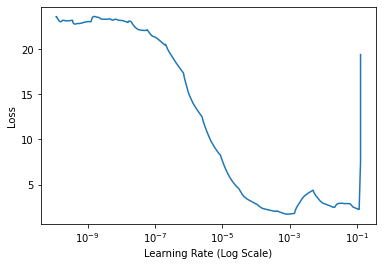

In [89]:
lrf.plot_loss()
plt.show()

In [82]:
lrf.plot_loss()
plt.savefig('/content/drive/My Drive/output/lrfind_plot.png')

* Review the generated plot.
* Update  MIN_LR  and MAX_LR, respectively.
* Train the network on our full dataset.



In [85]:
stepSize = STEP_SIZE * (trainX.shape[0] // BATCH_SIZE)
clr = CyclicLR(mode=CLR_METHOD,base_lr=MIN_LR,max_lr=MAX_LR,step_size=stepSize)


# Train the network

In [86]:
print("[INFO] training network...")
H = model.fit_generator(aug.flow(trainX, trainY, batch_size=BATCH_SIZE),
                        validation_data=(valX, valY),
                        steps_per_epoch=trainX.shape[0] // BATCH_SIZE,
                        epochs=NUM_EPOCHS,
                        callbacks=[clr],
                        verbose=1)

[INFO] training network...
Epoch 1/48
93/93 [==============================] - 44s 472ms/step - loss: 11.2160 - accuracy: 0.4117 - val_loss: 4.1047 - val_accuracy: 0.7568
Epoch 2/48
93/93 [==============================] - 42s 455ms/step - loss: 4.9481 - accuracy: 0.6999 - val_loss: 2.1985 - val_accuracy: 0.8589
Epoch 3/48
93/93 [==============================] - 42s 454ms/step - loss: 2.2288 - accuracy: 0.7713 - val_loss: 1.8523 - val_accuracy: 0.8709
Epoch 4/48
93/93 [==============================] - 43s 460ms/step - loss: 2.9029 - accuracy: 0.8065 - val_loss: 0.7528 - val_accuracy: 0.8919
Epoch 5/48
93/93 [==============================] - 42s 454ms/step - loss: 1.3423 - accuracy: 0.8258 - val_loss: 0.6266 - val_accuracy: 0.9009
Epoch 6/48
93/93 [==============================] - 42s 456ms/step - loss: 1.0537 - accuracy: 0.8413 - val_loss: 0.6401 - val_accuracy: 0.9039
Epoch 7/48
93/93 [==============================] - 42s 455ms/step - loss: 0.8559 - accuracy: 0.8440 - val_loss: 0

# Training Accuracy vs Validation Accuracy

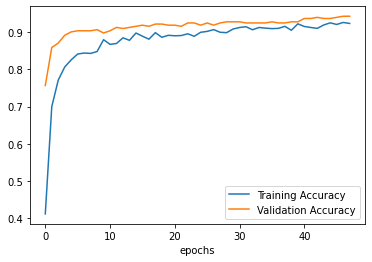

In [88]:
%matplotlib inline
plt.plot(H.history['accuracy'],label='Training Accuracy')
plt.plot(H.history['val_accuracy'],label='Validation Accuracy')
plt.legend()
plt.xlabel('epochs')
plt.show()

## Training Loss vs Validation Loss

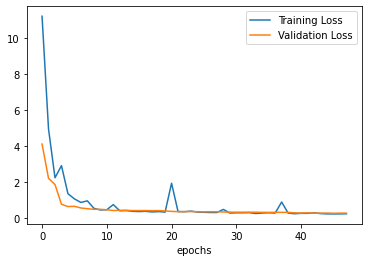

In [90]:
plt.plot(H.history['loss'],label='Training Loss')
plt.plot(H.history['val_loss'],label='Validation Loss')
plt.legend()
plt.xlabel('epochs')
plt.show()

#Evaluate the network and show a classification report

In [91]:
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=BATCH_SIZE)
print(classification_report(testY.argmax(axis=1),predictions.argmax(axis=1), target_names=CLASSES))

[INFO] evaluating network...
              precision    recall  f1-score   support

     Cyclone       0.96      0.97      0.97       205
  Earthquake       0.91      0.94      0.92       362
       Flood       0.90      0.88      0.89       273
    Wildfire       0.96      0.95      0.95       267

    accuracy                           0.93      1107
   macro avg       0.93      0.93      0.93      1107
weighted avg       0.93      0.93      0.93      1107



## Confusion Matrix

In [92]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(testY.argmax(axis=1),predictions.argmax(axis=1))

Text(33.0, 0.5, 'Actual Value')

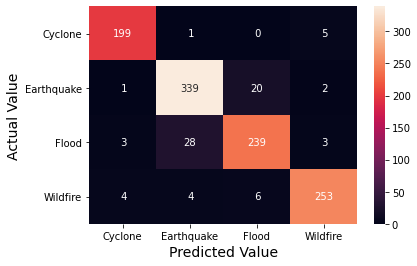

In [98]:
import seaborn as sns
sns.heatmap(cm,annot=True,fmt='2g',xticklabels=CLASSES,yticklabels=CLASSES)
plt.xlabel('Predicted Value',fontsize=14)
plt.ylabel('Actual Value',fontsize=14)

In [99]:
MODEL_PATH ="/content/drive/My Drive/output/natural_disaster.model"

'output/natural_disaster.model'

In [100]:
print("[INFO] serializing network to '{}'...".format(MODEL_PATH))
model.save(MODEL_PATH)

[INFO] serializing network to 'output/natural_disaster.model'...
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: output/natural_disaster.model/assets


# plot the learning rate history

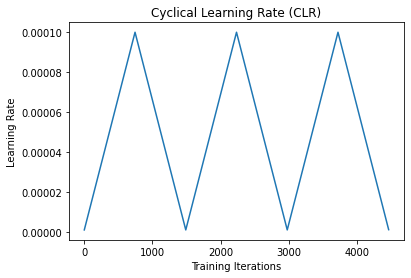

In [101]:
N = np.arange(0, len(clr.history["lr"]))
plt.figure()
plt.plot(N, clr.history["lr"])
plt.title("Cyclical Learning Rate (CLR)")
plt.xlabel("Training Iterations")
plt.ylabel("Learning Rate")
plt.show()